# Validation
Now that we have a basic handle on overfitting (and underfitting), we can start thinking about ways to minimize the problem. In a sense, each of the remaining sections in this tutorial focuses on a different kind of solution. In this section, we'll talk about model validation. While model validation doesn't *directly* prevent overfitting, it plays an important indirect role. If we don't have a good way to recognize overfitting when it happens, we're not going to be in a great position to mitigate it.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#scikit-learn stuff we've seen before
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from support import get_features

%matplotlib inline

In [14]:
data = pd.read_csv('data/Johnson-2014-IPIP-300.tsv.gz', sep='\t')

## Cross-validation using training and test sets
An important insight we already introduced in the last section is that an estimator will almost always perform better when evaluated on the same data it was trained on than when evaluated on an entirely new dataset. Since our estimators are usually not much use to us unless they can generalize to new data, we should probably care much more about how an estimator performs on new data than on data it's already seen.

The most straightforward way to obtain what's known as an *out-of-sample* performance estimate is to ensure that we always train and evaluate our estimator on independent datasets. The performance estimate obtained from the training dataset will typically suffer from overfitting to some degree; the test dataset estimate will not, so long as its error term is independent of the training dataset.

In practice, an easy way to construct training and test datasets with independent errors is to randomly split a dataset in two. We can make use of scikit-learn's `train_test_split` utility to do the work for us.

In [15]:
# a helpful utility that splits an arbitrary number of
# array-like objects into training and testing subsets
from sklearn.model_selection import train_test_split

# Get facet scores and age for a "full" sample of 1,000
items, age = get_features(data, 'items', 'AGE', n=1000)

# for every array we pass to train_test_split, we get back
# two: a training set, and a test set. the train_size
# parameter controls the proportion of all cases assigned
# to the training set (the remainder are assigned to test).
split_vars = train_test_split(items, age, train_size=0.5)

# Python supports parallel assignment: if the number of
# variables on the left side matches the number of
# elements in a list, the list elements will be mapped
# one-to-one onto the variables.
items_train, items_test, age_train, age_test = split_vars

# Verify shape...
items_train.shape

(500, 300)

Now we can fit our estimator using the training data, and evaluate its performance using both the training and test data. The difference between the two will tell us how badly we're overfitting to the training data. This practice is called *cross-validation*, and it's ubiquitous in machine learning. In most applications, if you report performance estimates from your training dataset without also reporting a corresponding cross-validated estimate, there's a good chance someone will (not unreasonably) yell at you.

In [18]:
est = LinearRegression()

est.fit(items_train, age_train)

# The .score() method implicitly calls predict(). The
# default scoring metric for LinearRegression is r2_score.
r2_train = est.score(items_train, age_train)
r2_test = est.score(items_test, age_test)

print(f"R^2 in training sample: {round(r2_train, 2)}")
print(f"R^2 in test sample: {round(r2_test, 2)}")

R^2 in training sample: 0.83
R^2 in test sample: -0.16


The difference here is pretty striking. In the training sample, the fitted model explains 60% of the variance. In the test sample, it explains... well, none. Actually, the value is negative!

If you're used to computing $R^2$ by taking the square of a correlation coefficient, you might be thinking that there must be an error somewhere. Correlations range from -1 to 1, and $R^2$ is the square of $R$, so how could we have a negative $R^2$ value?

The answer is that the [standard definition of $R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination) actually allows arbitrarily large negative values, because it's possible for the residual sum-of-squares (RSS) to be larger than the total sum-of-squares (TSS). Intuitively, we can have an estimator that's *so* bad at predicting new scores that we would have been better off just using the mean of the new data as our prediction. In fact, that's exactly what's happening in this case.

## K-fold cross-validation
Splitting our data into training and test sets is a great way to evaluate our model's out-of-sample performance, but it comes at a high cost: it actually increases the propensity to overfit. The reason for this is that we're effectively halving our training sample. As a result, our model has less data to work with, which means it will be more likely to capitalize on chance and fit noise (if this isn't completely intuitive to you yet, I suggest going back to the interactive plot at the end of the previous section and fiddling with it some more).

Is there a way to have our cake and eat it too? As it turns out, there is—at least, mostly. The solution is to use a form of cross-validation known as <i>k</i>-fold cross-validation. The idea here is very similar to splitting our data into training and testing halves. In fact, if we set <i>k</i>—a parameter that represents the number of *folds*, or data subsets—to 2, we again end up with two discrete subsets of the data.

But now, there's an important twist: instead of using one half of the data for training and the other half for testing, we're going to use both halves for both training and testing. The key is that we'll take turns. First, we'll use Half 1 to train, and Half 2 to test; then, we'll reverse the process. Our final estimate of the model's out-of-sample performance is obtained by averaging the performance estimates we got from the two testing halves. In this way, we've managed to use every single one of our data points for both training and testing, but—critically—never for both at the same time.

Of course, we don't have to set <i>k</i> to 2; we can set it to any other value between 2 and the total sample size <i>n</i>. At the limit, if we set <i>k = n</i>, the approach is called  *leave-one-out cross-validation* (because in every fold, we leave out a single data point for testing, and use the rest of the dataset for training). In practice, <i>k</i> is most commonly set to a value in the range of 3 - 10 (there are principled reasons to want to avoid large values of <i>k</i> in many cases, but we won't get into the details here).

<div align="center" style="font-size: 12px;"><img src="images/kfoldcv.png" width="900">
Image from <a href="http://karlrosaen.com/ml/learning-log/2016-06-20/">http://karlrosaen.com/ml/learning-log/2016-06-20/</a>
</div>

#### K-folds the explicit way
To illustrate how k-folds cross-validation works, let's implement it ourselves. First, we create <i>k</i> different subsets of the original dataset. Then, we loop over the <i>k</i> subsets and, in each case, use the current subset to test the model trained on the remaining <i>k</i>-1 subsets. Finally, we average over the performance estimates obtained from all <i>k</i> folds to obtain our overall out-of-sample performance estimate. If you're not interested in wading through the code, you can skip to the next subsection, where we replace most of this with a single line.

In [20]:
# Number of folds
K = 5

# initialize results placeholders
train_r2 = []
test_r2 = []

# our humble steed
est = LinearRegression()

# create list of indexes and randomize order. if we don't
# do this, our folds may be unbalanced if row order is
# confounded with other factors.
from random import shuffle
inds = list(range(len(items)))
shuffle(inds)

# Loop over the k folds
for k in range(K):

    # assign every index i to one of k clusters. note that
    # the conditional will only pass for (1/k)% of indices
    train = [x for (i, x) in enumerate(inds) if i % K != k]

    # any indices not in the training set must be in the test
    test = list(set(inds) - set(train))

    # assign X and y train/test subsets to new variables
    X_train, X_test = items.iloc[train], items.iloc[test]
    y_train, y_test = age.iloc[train], age.iloc[test]
    
    # fit the linear regression to only the training data
    est.fit(X_train, y_train)
    
    # compute scores separately for train and test
    _train_r2 = est.score(X_train, y_train)
    _test_r2 = est.score(X_test, y_test)

    # save the R2 scores for this fold
    train_r2.append(_train_r2)
    test_r2.append(_test_r2)

# compute the mean r2 values over all folds
train_mean = np.array(train_r2).mean()
test_mean = np.array(test_r2).mean()

# let's see...
print(f"Mean training R^2 over folds: {train_mean:.2f}")
print(f"Mean training R^2 over folds: {test_mean:.2f}")

Mean training R^2 over folds: 0.69
Mean training R^2 over folds: 0.11


Notice that our out-of-sample predictive performance is now much better than it was before. Why do you think this is?

#### K-folds the easy way
K-folds is an extremely common validation strategy, so any machine learning package worth its salt should provide us with some friendly tools we can use to avoid having to reimplement the basic procedure over and over. In scikit-learn, the `cross_validation` module contains several useful utilities. We've already seen `train_test_split`, which we could use to save us some time. But if all we want to do is get cross-validated scores for some estimator, it's even faster to use the `cross_val_score` function:

In [22]:
from sklearn.model_selection import cross_val_score

# number of folds
K = 10

est = LinearRegression()

# cross_val_score takes an estimator, our variables, and an
# optional specification of the cross-validation procedure.
# integers are interpreted as the number of folds to use
# in a k-folds partitioning.
r2_cv = cross_val_score(est, items, age, cv=K)

print("Individual fold scores:", r2_cv)
print(f"\nMean cross-validated R^2: {r2_cv.mean():.2f}")

Individual fold scores: [ 0.05355187 -0.61187673  0.20610567  0.24403723  0.42825949  0.36267644
  0.11662817 -0.27198738  0.2705856   0.17144808]

Mean cross-validated R^2: 0.10


That's it! We were able to replace nearly all of our code above with one function call. If you find this a little *too* magical, scikit-learn also has a bunch of other utilities that offer an intermediate level of abstraction (e.g., the `sklearn.model_selection.KFold` class will generate the folds for you, but will return the training and test indices for you to loop over, rather than automatically cross-validating your estimator).

Notice that, once again, our cross-validated estimate is a little bit higher than it was in the previous version. The explanation for this improvement is the same as before. (*Hint*: what happens to the training/test allocation as we increase the number of folds? And for bonus points, why might we not automatically want to use the largest value of *k*—i.e., leave-one-out-cross-validation—just because it's likely to give us a more favorable estimate of performance?)

## Learning and validation curves

So far, we've focused on cross-validating model performance at a single point in dataset and parameter space. That is to say, we're asking "how well would our fitted model do if we took it exactly as-is, changing none of its parameters, and applied it to a new dataset sampled from exactly the same population?"

This is an important thing to know, but we can do better. If we want to get deeper insights into a model's behavior, we need a good way to observe the way it responds when we systematically vary the size and nature of the data, number and type of features, model hyperparameters, etc.

In scikit-learn, we can use the `learning_curve` and `validation_curve` utilities to flexibly and compactly wrap most of the cross-validation functionality we've already encountered. The idea behind the [learning curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) is to graphically display a model's predictive performance as a function of the model's experience—i.e., to visualize how well it learns as the available data grows. The `validation_curve` is directly analogous, except instead of varying the size of the data, we systematically vary one of the estimator's parameters.

We'll defer more detailed discussion of the validation curve to a later section; for now, let's look at the `learning_curve`. Here's an example:

In [23]:
from sklearn.model_selection import learning_curve

# we'll predict age from the 30 facet scores
facets, age = get_features(data, 'facets', 'AGE')

# The sizes of the datasets we want to evaluate our estimator at
train_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]

est = LinearRegression()

# obtain learning curve. as with the cross_val_score utility,
# the cross-validated application of our estimator is done
# implicitly for us.
results = learning_curve(est, facets, age, train_sizes=train_sizes,
                         cv=5, shuffle=True)
sizes, train_scores, test_scores = results

The `train_scores` and `test_scores` arrays contain the performance scores for training and testing data, respectively. The rows reflect training sizes (i.e., in our case, the first row gives performance n=100, the second for n=200, etc.) and the columns contain the scores from the <i>k</i> folds of the k-folds cross-validation procedure.

In [24]:
train_scores.round(2)

array([[0.45, 0.52, 0.53, 0.62, 0.56],
       [0.33, 0.43, 0.36, 0.47, 0.34],
       [0.29, 0.38, 0.32, 0.31, 0.24],
       [0.29, 0.29, 0.28, 0.3 , 0.22],
       [0.26, 0.31, 0.25, 0.28, 0.23],
       [0.25, 0.27, 0.25, 0.25, 0.26],
       [0.25, 0.26, 0.25, 0.25, 0.26],
       [0.25, 0.26, 0.25, 0.26, 0.26],
       [0.25, 0.25, 0.25, 0.25, 0.26]])

This information is fairly hard to appreciate in tabular form, so let's average performance over the columns (i.e., the <i>k</i> folds) and plot it as a function of the sample size.

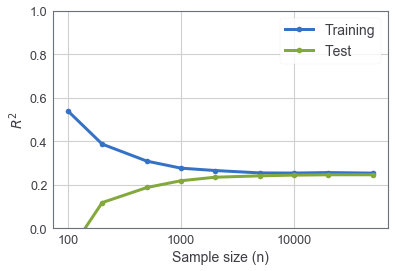

In [25]:
from matplotlib.ticker import ScalarFormatter

train_mean = train_scores.mean(1)
test_mean = test_scores.mean(1)
plt.plot(sizes, train_mean, 'o-', label='Training', lw=3)
plt.plot(sizes, test_mean, 'o-', label='Test', lw=3);
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.grid(True, axis='y')
plt.legend(fontsize=14)
plt.ylim(0, 1)
plt.xlabel('Sample size (n)', fontsize=14)
plt.ylabel('$R^2$', fontsize=14);

Inspecting the relationship between the training and testing curves in the above plot can tell us several important things about the behavior of our estimator (in this case, ordinary least-squares regression). We already observed in section 2 that performance in the training set appears to decrease with sample size—at least in this particular case (this is not a general rule). At the time, we speculated that this trend was illusory—i.e., it's not that our estimator really gets worse as we give it more data, but that its propensity to overfit when sample size is small leads us to *think* it's performing better than it really is early on in the curve.

We can now confirm this hypothesis by looking at the performance of our estimator in the test data. In contrast to the training data, $R^2$ improves monotonically as the training dataset gets larger. This *is* a general rule: a model's out-of-sample performance should only get better as it's trained on more data.

Note also that a certain point, as sample size grows, the two lines will converge. This is an indication that we should consider increasing the flexibility of our model. The fact that our model performs no better in the training set than the test set means that we've stopped learning from our data. While overfitting is generally a bad thing, its presence does at least signal that we're still gaining new information, and can benefit from increasing the sample size.

##### Training vs. test vs. validation : a note on nomenclature
Before moving on, a quick note on nomenclature: you will sometimes hear people talk about "validation" sets rather than (or in addition to) training and test sets. What this means depends on the context. In many cases, the terms test set and validation set are used interchangeably to refer to a new dataset independently of the one the model is trained on. But sometimes, the distinction between validation and test is important. In particular, it's common to set aside a "true" hold-out dataset in advance of any validation efforts. In such cases, the test dataset is the one we use to obtain our final, no-takesies-backsies estimate of performance. The validation dataset, by contrast, is technically part of the training data (in that we allow ourselves to use it to train the final model), but it's being used for validation. When we perform a cross-validation procedure on a training set, we call the hold-out folds the validation sets.

This kind of 3-way split of our data is an excellent way to operate, as it ensures that we're able to detect overfitting that occurs not only during model estimation, but also in the model selection process (e.g., if we "cross-validate" 100 models and then choose the one with the best cross-validated performance, we're still going to overfit to some degree, and performance in the test dataset will reveal this).

<div align="center" style="font-size: 12px;">
<img src="images/trainvaltest.png">
Image from <a href="https://medium.com/@hi.martinez/train-test-split-cross-validation-you-b87f662445e1">https://medium.com/@hi.martinez/train-test-split-cross-validation-you-b87f662445e1</a>
</div>

### Dataset size and model complexity
So far we've looked at the relationship between training dataset size and model performance. Now we'll add another dimension to the picture, and try to get a qualitative sense of how our training and validation curves vary as a function of model complexity—which in this case we'll operationalize as the number of predictors our linear regression estimator gets to use. 

To save ourselves a lot of code, we'll use a `plot_learning_curves` helper function I've written that wraps the `learning_curve` utility we used to produce the curves in the previous plot. It'll enale us to easily generate plots with multiple panels, where each panel shows the learning curve when plotted for a different dataset and/or estimator.

Let's start by asking how well we can predict age given our three different predictor sets—the domains, facets, and items, respectively. These sets contain 5, 30, and 300 features, respectively. We'll once again evaluate performance for sample sizes ranging from 100 to 50,000. For the time being, we'll stick with ordinary least-squares regression as our estimator.

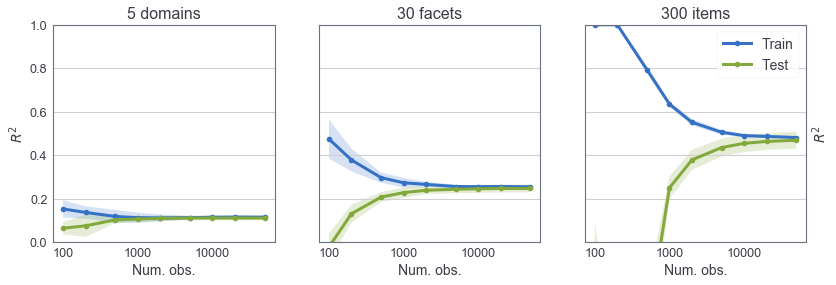

In [26]:
# the aforementioned plotting helper
from support import plot_learning_curves

# we'll compare performance for three different sets of predictors:
# the 5 domains, 30 facets, and 300 items. note the *X_sets
# notation; this is an advanced iterable unpacking trick that
# only works in Python 3. it lets the variable preceded by the
# star "swallow" any variables that aren't explicitly assigned.
*X_sets, age  = get_features(data, 'domains', 'facets', 'items', 'AGE')

# training sizes remain the same in our previous examples
train_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]

# titles for each of the plot panels
labels = ['5 domains', '30 facets', '300 items']

# we pass plot_learning_curves an estimator, the list of feature
# #sets, the outcome variable, and the train_sizes and labels
plot_learning_curves(LinearRegression(), X_sets, age, train_sizes, labels=labels)

There are a couple of new points to note here:

1. Our ability to predict age varies dramatically depending on which features we use. Looking at the terminal point of each test curve (representing the K-fold cross-validated performance estimate at the largest sample size), we see that we do much better with 300 items than with 30 facets, and much better with the 30 facets than with just the 5 domains.

2. When sample size is small, we actually do a better job predictively using a smaller set of features. For example, at n = 500, we can explain about 20% of the variance in the test set using 30 facets, whereas our 300-item model is basically useless. By contrast, if we paid attention solely to the (overfitted) training set estimates, we would be misled into thinking that the 300-item model performs much better than the 30-facet model (~80% of the variance vs. 30%).

3. The point at which the training and test curves converge shifts systematically to the right with increasing model complexity.

Points (2) and (3) illustrate a general relationship between model complexity and dataset size: the more complex a model, the greater its capacity to learn from the data, but the more data we need in order to avoid overfitting. This tradeoff is unavoidable, and means that we need to think carefully (and conduct validation analyses like the one above!) when constructing our model.

##### A personality tangent: What's beyond the Big Five?
For readers interested in personality psychology, there's an additional dimension to this analysis that may be of interest: notice just how *much* of the variance in age can be explained by the 300 individual items, despite lying outside the reach of the Big Five domains, or even the 30 facets. This is an instructive result, because there's a long history in personality psychology of people arguing over whether or not there's anything ["beyond the Big Five"](https://darkwing.uoregon.edu/~gsaucier/Saucier-WhatisBeyondThe5.pdf). Hopefully, the above demonstration convinces you that there's a great deal to personality that isn't captured by thirty face scales, let alone by just five major dimensions.

### Generalizing to different populations
The fact that the learning curve shows a convergence between the training and test samples (at least when our sample is larger) provides some assurance that our model will continue to perform comparably well when tested on new observations sampled from the same population. This does *not*, however, mean that performance will remain comparable when tested on new *populations*. If our goal is to generalize beyond the population we sampled from in our training sample, it's advisable to compute validation curves that evaluate generalization performance in as realistic a way as possible.

For example, if we intend to apply our age-prediction model to countries that are undersampled in our existing data (or not sampled at all), we might want to quantify how well the model generalizes across countries that *are* adequately sampled. Let's take a look at the country representation in our Johnson (2014) dataset:

In [27]:
# Show 20 most common countries in the dataset
data['COUNTRY'].value_counts()[:20]

USA            100608
Canada          10382
UK               7680
Australia        4978
Netherlands      1853
India            1218
Thailand         1156
Singapore        1149
Philippines      1088
Finland           992
New Zealand       911
Ireland           904
Sweden            738
Germany           574
Norway            520
China             484
South Afric       406
France            398
Malaysia          394
Hong Kong         356
Name: COUNTRY, dtype: int64

There's far more data from US participants than other countries, so let's train our linear regression model—once again predicting age from the 300 items—on half of the US subset. Then we'll evaluate its performance both in the other half of the US subset, and in the full sample for several other countries (all those with more than 500 data points).

In [28]:
# Split US data in two
us_data = data.query('COUNTRY == "USA"')
n_usa = len(us_data)
inds = np.random.choice(n_usa, n_usa // 2,  replace=False)
us_train = us_data.iloc[inds]
us_test = us_data.iloc[~inds]

# Train model and evaluate in-sample
model = LinearRegression()
items, age = get_features(us_train, 'items', 'AGE')
model.fit(items, age)
train_score = r2_score(age, model.predict(items))
print(f"R^2 in training half of US sample: {train_score:.2f}")

# Evaluate in testing half of US data
items, age = get_features(us_test, 'items', 'AGE')
test_score = r2_score(age, model.predict(items))
print(f"R^2 in testing half of US sample: {test_score:.2f}\n")

# Get data for all countries other than USA with >= 500 observations
countries = data.groupby('COUNTRY').filter(lambda x: len(x) >= 500)
countries = countries.query('COUNTRY != "USA"')

# Loop over countries and test performance in each one
results = []
for name, country_data in countries.groupby('COUNTRY'):
    items, age = get_features(country_data, 'items', 'AGE')
    country_score = r2_score(age, model.predict(items))
    n_obs = len(country_data)
    results.append([name, round(country_score, 2), n_obs])

results = pd.DataFrame(results, columns=['country', 'R^2', 'n'])
print("Other countries:")
results.sort_values('R^2', ascending=False)

R^2 in training half of US sample: 0.50
R^2 in testing half of US sample: 0.50

Other countries:


,country,R^2,n
5,Ireland,0.50,904
1,Canada,0.48,10382
0,Australia,0.46,4978
7,New Zealand,0.45,911
13,UK,0.44,7680
6,Netherlands,0.30,1853
11,Sweden,0.30,738
3,Germany,0.25,574
8,Norway,0.21,520
2,Finland,0.14,992


We observe that our US-trained model does very well for people living in other English-speaking countries, but predicts age more poorly for non-English-speaking Western countries (e.g., Finland and Germany), and is basically useless for age prediction in non-English-speaking countries.

Does this mean that the relationship between personality and age genuinely varies across age, or is this simply a reliability issue—i.e., that we shouldn't trust personality scores on an English-language measure when provided by non-native English speakers? The above results don't directly tell us (though the fact that our age prediction model is useless even in Singapore, a country with high English literacy, might push us to suspect the former). We could of course pursue this question further—for example, by reversing our approach and training the model on non-English speakers, or by conducting an item analysis to see if we can identify items that substantially change their predictive value across cultures.

In any case, the main point should hopefully be clear: it's a bad idea to assume that a particular pattern or prediction (even an extremely strong one, as in this case!) is going to generalize to different contexts. Fortunately, as long as we have data that spans multiple contexts, common cross-validation strategies allow us to directly estimate the generalizability of our model, rather than taking it as an article of faith.